In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")

pd.options.display.max_columns = None

from speech_study.audio_ptcpt_filtering import add_audio_mask
from speech_study.data_parsing import add_condition_mask
from speech_study.path_conf import loc_data_dir


# Utterance - repetition analysis

In this study, participants were instructed to read aloud the same text at 9 different moments.<br>
This repetitive reading task, together with the fixed order of the *control first, then negative* feedback task, can possibbly hinder the interpretation of our obtained results. 

This notebooks visualizes our analyzed speech features w.r.t. the `fileNum` (a.k.a repetition count).

In [3]:
df_gemaps_func = pd.read_parquet(loc_data_dir / "df_gemaps_func.parquet")
df_func_begin = pd.read_parquet(
    loc_data_dir / "df_gemaps_func_dur_begin.parquet", engine="fastparquet"
)
df_func_end = pd.read_parquet(
    loc_data_dir / "df_gemaps_func_dur_end.parquet", engine="fastparquet"
)


In [4]:
metadata_cols = [
    "file",
    "start",
    "end",
    "fileName",
    "fileNum",
    "participantNum",
    "arousal",
    "valence",
    "dominance",
    "condition",
]

relevant_feat_cols = [
    "F0semitoneFrom27.5Hz_sma3nz_amean",
    # "F0semitoneFrom27.5Hz_sma3nz_stddevNorm",
    # "F0semitoneFrom27.5Hz_sma3nz_percentile20.0",
    # "F0semitoneFrom27.5Hz_sma3nz_percentile50.0",
    # "F0semitoneFrom27.5Hz_sma3nz_percentile80.0",
    "HNRdBACF_sma3nz_amean",
    # "loudness_sma3_stddevNorm",
    # "loudness_sma3_percentile20.0",
    # "loudness_sma3_percentile50.0",
    # "loudness_sma3_percentile80.0",
    "jitterLocal_sma3nz_amean",
    # "jitterLocal_sma3nz_stddevNorm",
    "shimmerLocaldB_sma3nz_amean",
    # "shimmerLocaldB_sma3nz_stddevNorm",
    # "HNRdBACF_sma3nz_stddevNorm",
    # "loudness_sma3_amean",
    # "loudnessPeaksPerSec",
    "VoicedSegmentsPerSec",
    "MeanVoicedSegmentLengthSec",
    # "StddevVoicedSegmentLengthSec",
    # "MeanUnvoicedSegmentLength",
    # StddevUnvoicedSegmentLength
]


feat_cols = list(set(df_func_end.columns).difference(metadata_cols))

df_delta = df_func_begin.set_index("file").sort_index()
# Filter out the too low HNR
df_delta = df_delta[
    df_delta.HNRdBACF_sma3nz_amean
    > 0 & (df_func_end.set_index("file").sort_index().HNRdBACF_sma3nz_amean > 0)
]
df_delta[feat_cols] -= df_func_end.set_index("file")[feat_cols]

add_condition_mask(df_delta)
add_audio_mask(df_delta)

add_condition_mask(df_gemaps_func)
_ = add_audio_mask(df_gemaps_func)


### Full duration

In [5]:
df_gemaps_func_norm = df_gemaps_func[df_gemaps_func.HNRdBACF_sma3nz_amean > 0].copy()
df_gemaps_func_norm[relevant_feat_cols] -= df_gemaps_func_norm.groupby(
    "participantNum"
)[relevant_feat_cols].transform("mean")


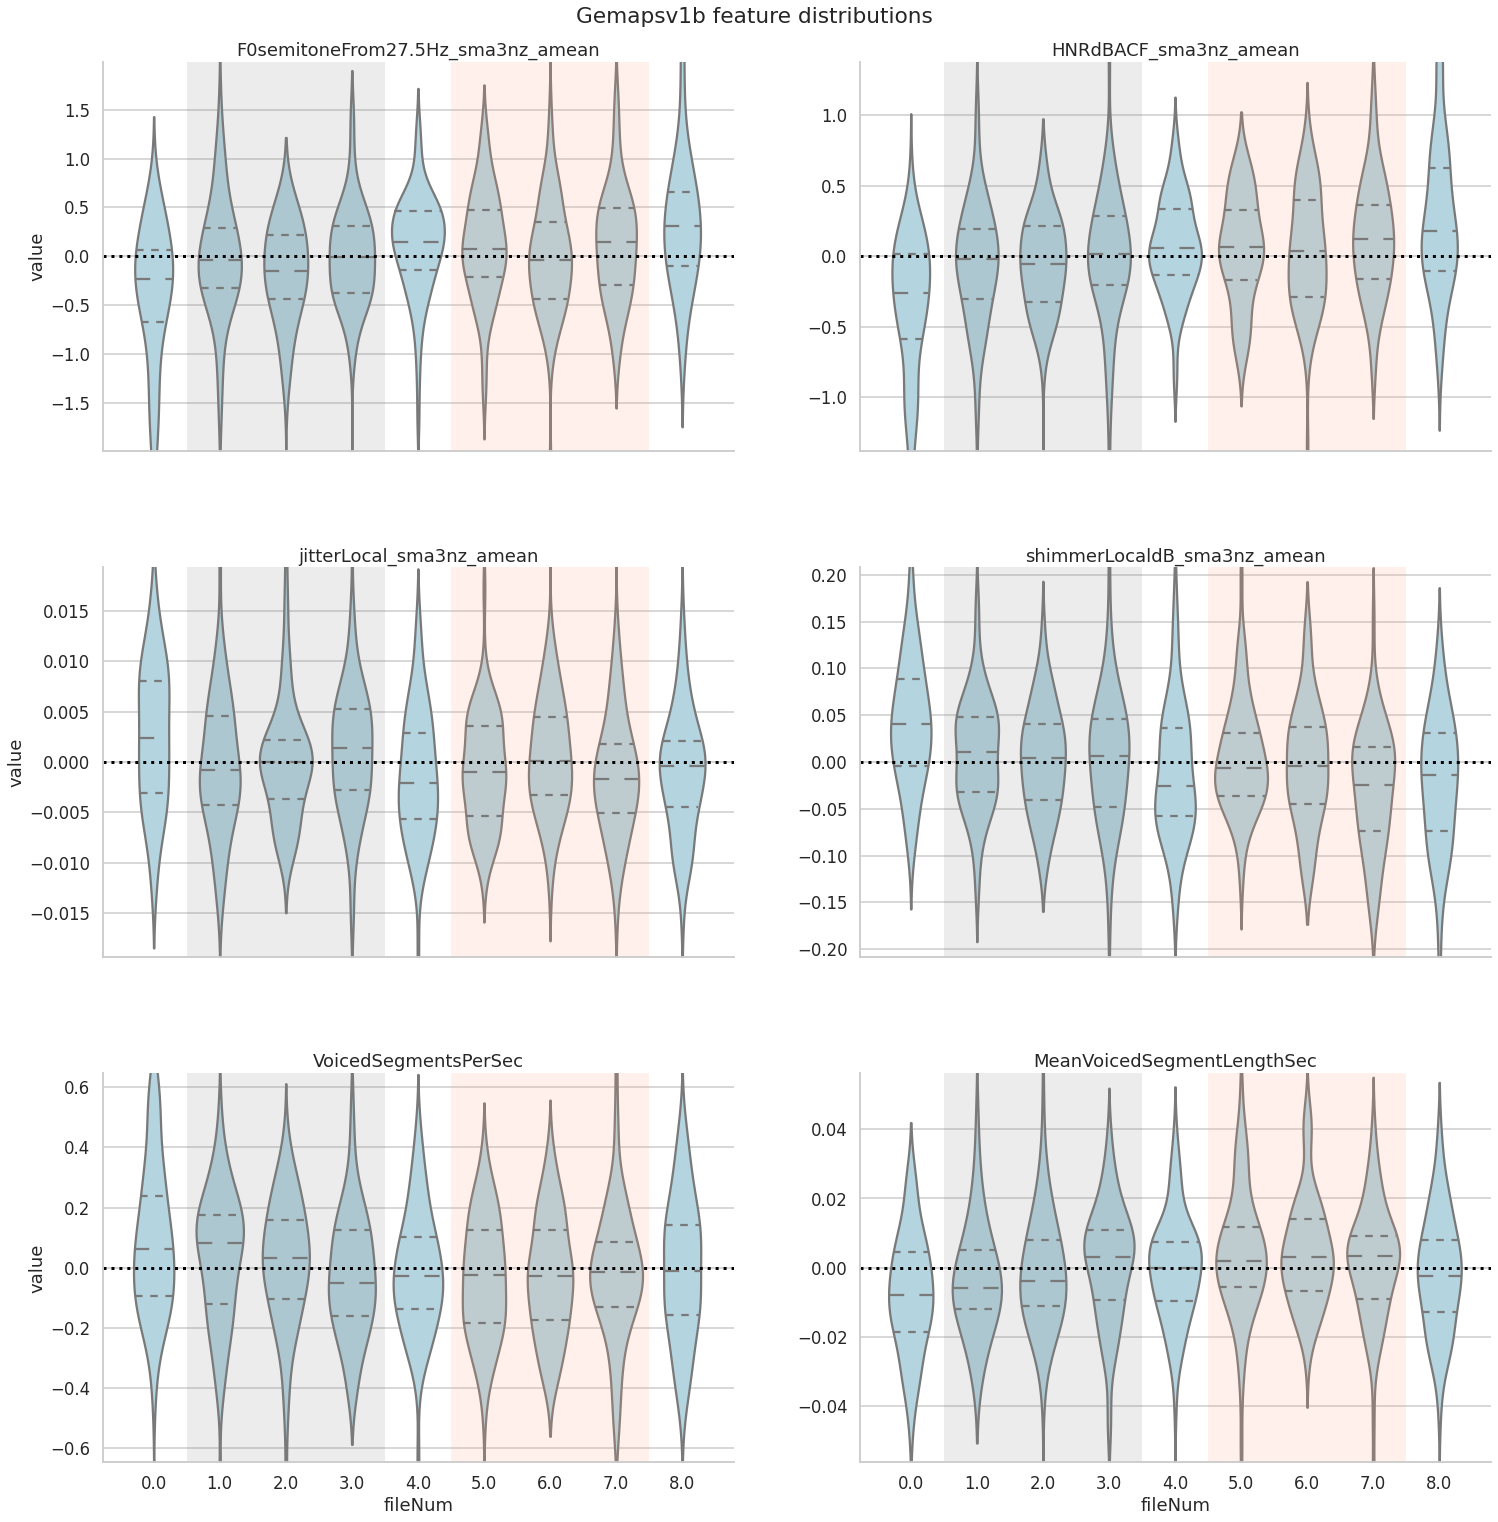

In [6]:
sns.set_context("talk")
sns.set_style("whitegrid")
g = sns.catplot(
    data=pd.melt(
        frame=df_gemaps_func_norm[
            (~df_gemaps_func_norm.bad_audio)
            # & (df_gemaps_func_norm["HNRdBACF_sma4nz_amean"] > 2)
        ],
        id_vars=["file", "fileName", "fileNum", "condition", "participantNum"],
        value_vars=relevant_feat_cols,
        value_name="value",
        var_name="speech_feature",
    ),
    x="fileNum",
    y="value",
    col="speech_feature",
    col_wrap=2,
    height=7,
    aspect=1.5,
    kind="violin",
    inner="quartile",
    sharey=False,
    color="lightblue",
    sharex=True,
)

g.set_titles("{col_name}")
g.fig.suptitle("Gemapsv1b feature distributions", y=1.01)
plt.subplots_adjust(wspace=0.2, hspace=0.3)

for ax, std_range in zip(
    g.axes, df_gemaps_func_norm[relevant_feat_cols].describe().T["std"]
):
    ax.axvspan(0.5, 3.5, color="grey", alpha=0.15, lw=0)
    ax.set_ylim(-3 * std_range, 3 * std_range)
    ax.axvspan(4.5, 7.5, color="lightsalmon", alpha=0.15, lw=0)
    ax.axhline(y=0, c="black", ls=":", lw=3)


### Intra utterance difference: begin - end

This visualization subtracts the functional of the last 7 seconds from the functional of the first 7 seconds for same utterances.

$func_{t0_s-7_s} - func_{tNEG7_s-end}$



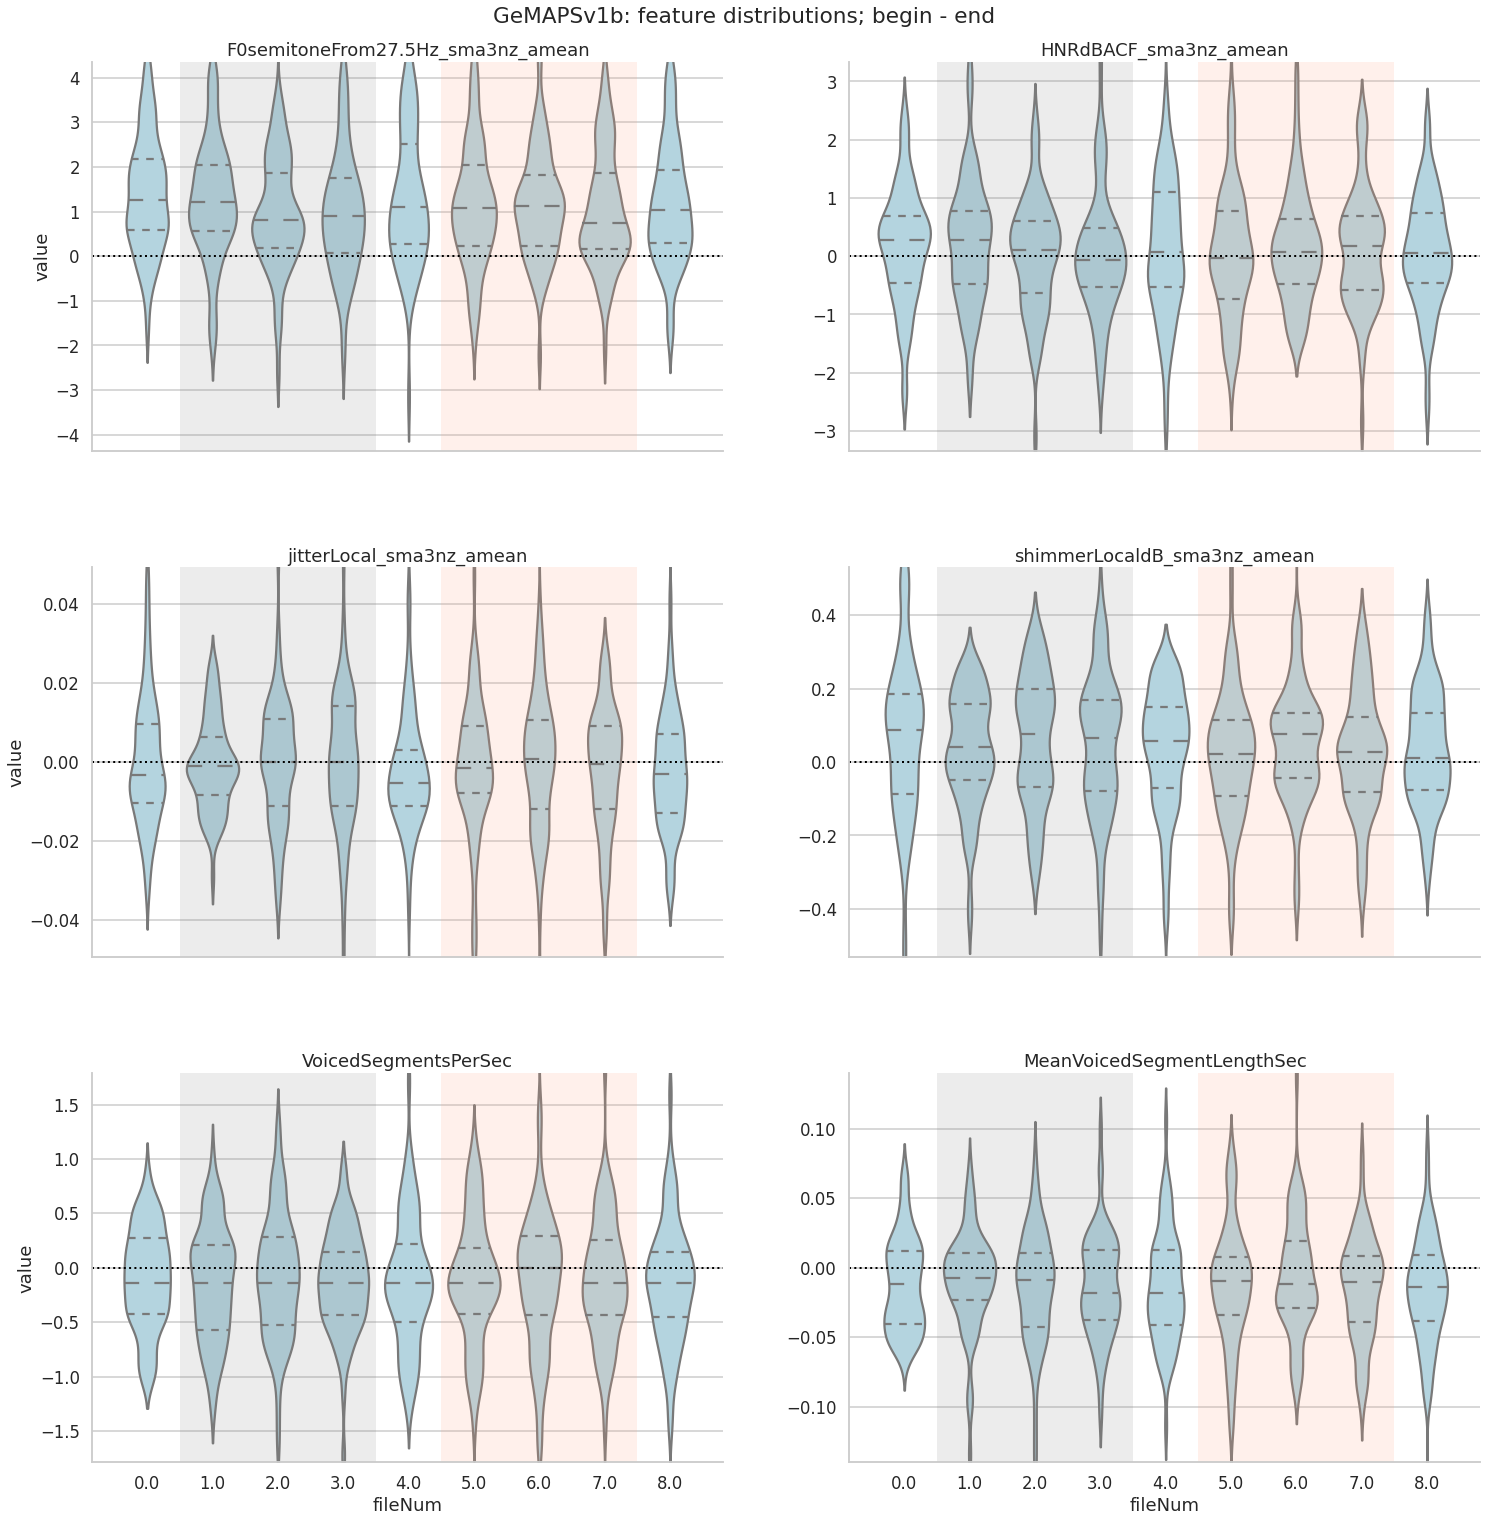

In [7]:
g = sns.catplot(
    data=pd.melt(
        frame=df_delta[
            (~df_delta.bad_audio)
        ],
        id_vars=["fileName", "fileNum", "condition", "participantNum"],
        value_vars=relevant_feat_cols,
        value_name="value",
        var_name="speech_feature",
    ),
    x="fileNum",
    y="value",
    col="speech_feature",
    col_wrap=2,
    height=7,
    aspect=1.5,
    # kind="box",
    bw=0.3,
    kind='violin',
    inner='quartile',
    color="lightblue",
    sharey=False,
    sharex=True,
    # showfliers=False,
)
g.set_titles("{col_name}")
g.fig.suptitle("GeMAPSv1b: feature distributions; begin - end", y=1.01)

for ax, std in zip(g.axes, df_delta[relevant_feat_cols].describe().T["std"]):
    ax.axvspan(0.5, 3.5, color="grey", alpha=0.15, lw=0)
    ax.axvspan(4.5, 7.5, color="lightsalmon", alpha=0.15, lw=0)
    ax.set_ylim(-3 * std, 3 * std)
    ax.axhline(y=0, c="black", ls=":", lw=2)
plt.subplots_adjust(wspace=.2, hspace=.3)
